In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import regex as reg
%matplotlib inline

Loading the data about universities:

In [2]:
universities = pd.read_pickle('data/Universities.pkl')
universities.head()

,file,name,domain,email,author_order,country,Lat,Lon
0,import2018_371,University of Colorado at Boulder,colorado.edu,rebecca.swanson@colorado.edu,0,United States,40.006667,-105.267222
1,import2018_371,University of Colorado at Boulder,colorado.edu,leighanna.hinojosa@colorado.edu,1,United States,40.006667,-105.267222
2,import2018_371,University of Colorado at Boulder,colorado.edu,joseph.polman@colorado.edu,2,United States,40.006667,-105.267222
3,import2018_417,Indiana University at Bloomington,indiana.edu,huang220@indiana.edu,0,United States,39.167222,-86.521389
4,import2018_417,Indiana University at Bloomington,gmail.com,agomoll90@gmail.com,1,United States,39.167222,-86.521389


In [3]:
universities.rename(columns={'email': 'mail'}, inplace=True)

## Mapping the participants:


A first overview of the community is given by looking at where the participants are from. Note that where a participant is from is determined by the location of the institution the are associated with. 
The size of the dot is choose based on the number of participants affiliated with that location. Each dot is set to be transparent so that locations with a more opaque coloring indicate a dense cluster of institutions participating.

We see that the eastern coast of north america and western europe show large dense clusters of participants. Furthermore, finland, israel, australia and japan have a large community of participants.

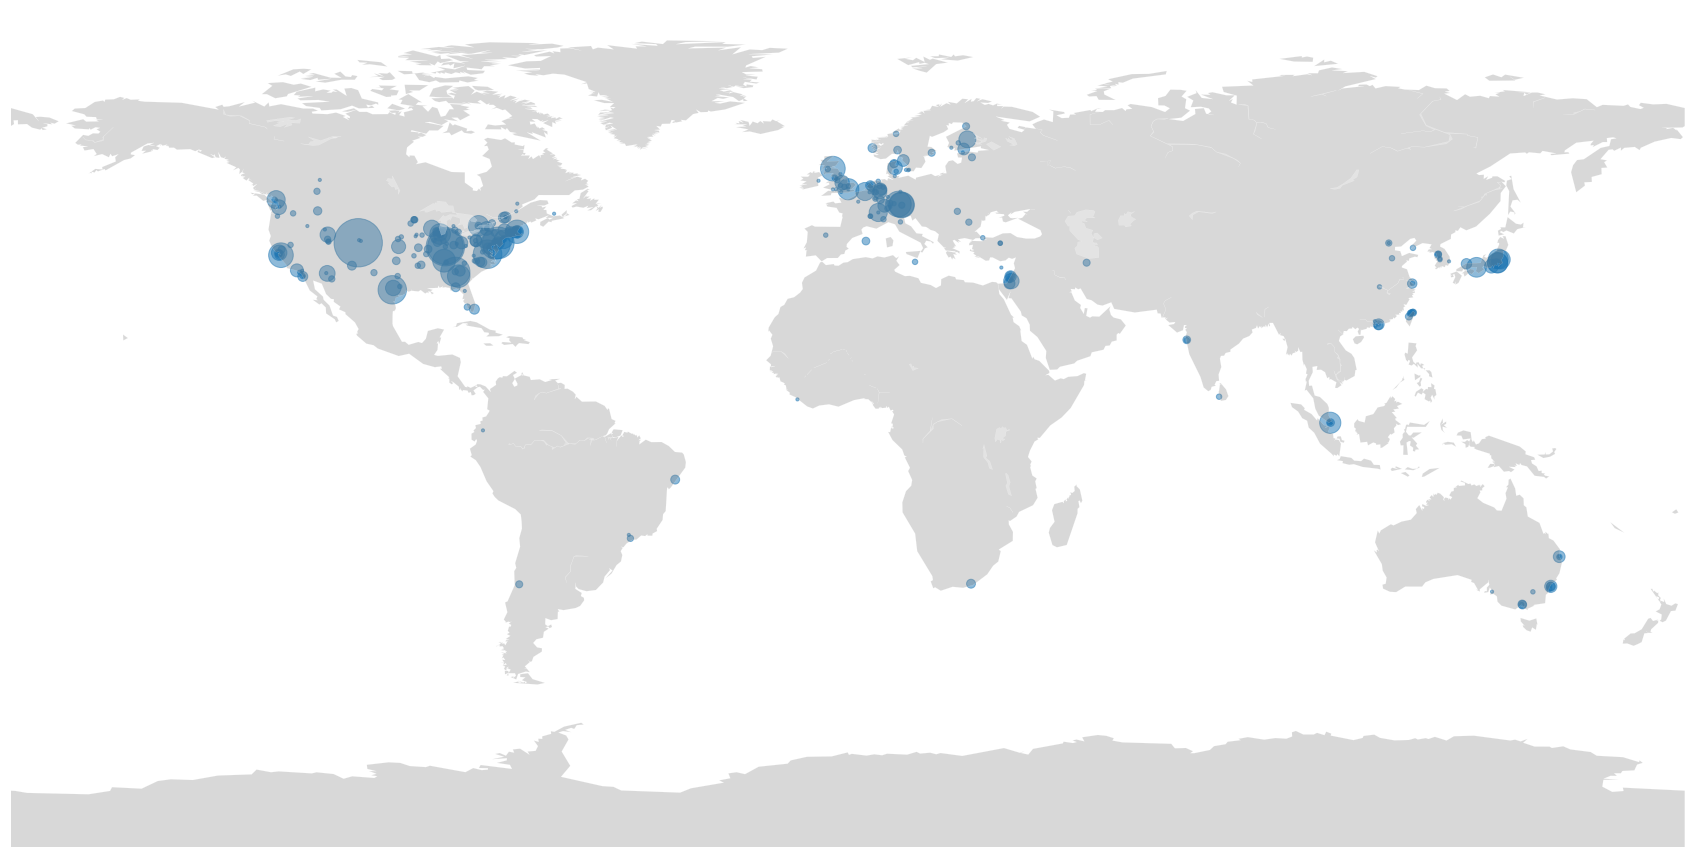

In [4]:
from mpl_toolkits.basemap import Basemap
#run export PROJ_LIB=$CONDA_PREFIX/share/proj if this gives a key error

plt.figure(figsize=(30, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
data = universities.drop_duplicates()
 
# Add a point per position
m.scatter(data[~data.name.duplicated()]['Lon'], 
          data[~data.name.duplicated()]['Lat'], 
          s= universities.name.value_counts()*10, 
          alpha=.5)


## Base analysis of Universities present in dataset


Here we try to answer some basic questions regarding distribution of participants overall, how it varies by year, and look at ICLS and CSCL years

#### What universities has the most contributors, and what percentage do they make up:

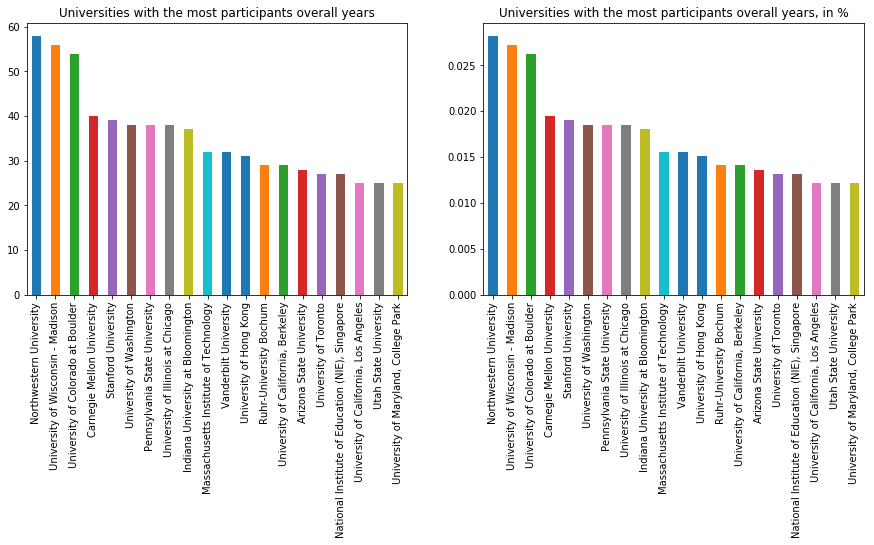

In [5]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Universities with the most participants overall years')
universities[(~universities.mail.duplicated())].name.value_counts().head(20).plot(kind='bar')

plt.subplot(122)
plt.title('Universities with the most participants overall years, in %')
(universities[(~universities.mail.duplicated())].name.value_counts().head(20)/universities[(~universities.mail.duplicated())].shape[0]).plot(kind='bar')
plt.show()

#### What are the countries where the most contributors are?

As determined by university affiliation

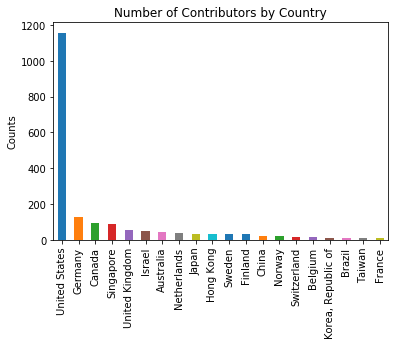

In [6]:
universities[(~universities.mail.duplicated())].country.value_counts().head(20).plot(kind = 'bar')
plt.title('Number of Contributors by Country') # as determinded by university affiliation
plt.ylabel('Counts')
plt.show()

## Considering ICLS and CSCL:

We look at which universities are present every year, only present during CSCL years and ICLS years:

In [7]:
universities['merge_index'] = universities.apply(lambda x: x['file']+str(x['author_order']), axis=1)

metadata = pd.read_csv('data/Parsed_metadata.csv', index_col=0, parse_dates=['accessioned', 'available', 'issued'])
metadata.issued = metadata.issued.map(lambda x: x.year)
metadata['merge_index'] = metadata.apply(lambda x: x['file']+str(x['author_order']), axis=1)
associations = pd.merge(universities, metadata, on='merge_index')

In [8]:
associations.rename(columns={'file_x': 'file'}, inplace=True)

Small note on the assumption made to avoide double counting participants: one person lists the same email in papers written by that person within the same year. This is not necessarily true for everybody, but currently we can not check based on name due to a variety of issues with the data (Naming order inconsistency, Naming inconsistency) 

In [9]:
#dataframe with paper - author - author affiliations
grouping =  associations.copy()
grouping = grouping[#only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated()) ]

In [10]:
#get universities by year
uni_year = grouping.groupby('issued').apply(lambda x: set(x['name']))

#get years in our dataset
years = uni_year.index.tolist()

#create a set of universities that have participated at some point
unis = uni_year.tolist()
all_ = set()
[all_.update(x) for x in unis]

#now use odd and even years to determine universities that participated every year in either ICLS or CSCL

all_years = unis[0]
ICLS = all_
CSCL = all_
for i, x in enumerate(unis):
    all_years = all_years.intersection(x)
    
    if years[i] % 2 == 0:
        ICLS = ICLS.intersection(x)
    else:
        CSCL = CSCL.intersection(x)

We now focus on universities that participated uniquely on one or the other conference:

In [11]:
ICLS, CSCL = ICLS.difference(CSCL), CSCL.difference(ICLS)

In [12]:
print('Number of universities represeted every year: ', len(all_years))
print('Number of universities represeted at every ICLS but not CSCL: ', len(ICLS))
print('Number of universities represeted at every CSCL but not ICLS: ', len(CSCL))

Number of universities represeted every year:  37
Number of universities represeted at every ICLS but not CSCL:  55
Number of universities represeted at every CSCL but not ICLS:  9


We now look into publication counts per university over the years:

In [13]:
grouping =  associations.copy()
grouping = grouping[ #only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated()) & 
                    #only consider universities that participated every year
                    (grouping.name.isin(all_years))]

ranks = pd.DataFrame(grouping.groupby('issued').name.value_counts())
ranks.columns = ['count']
ranks.reset_index(inplace=True)
#look at how the dataframe is formated
ranks.head()

,issued,name,count
0,2015,University of Toronto,12
1,2015,Göteborg University,9
2,2015,Universität Duisburg-Essen,9
3,2015,EPFL - EPF Lausanne,8
4,2015,Indiana University at Bloomington,8


There seems to be some pattern indicating that even amongst universities that participate every year, there is a fluctuation of number of papers submitted by each university to ICLS and CSCL.

In [14]:
#we only look at universities that have at least two submissions  each year
all_ = set()
ranks[ranks['count'] > 2].groupby('issued').apply(lambda x: all_.update(set(x['name'])))

for s in ranks[ranks['count'] > 2].groupby('issued').apply(lambda x: set(x['name'])).tolist():
    all_ = all_.intersection(s)

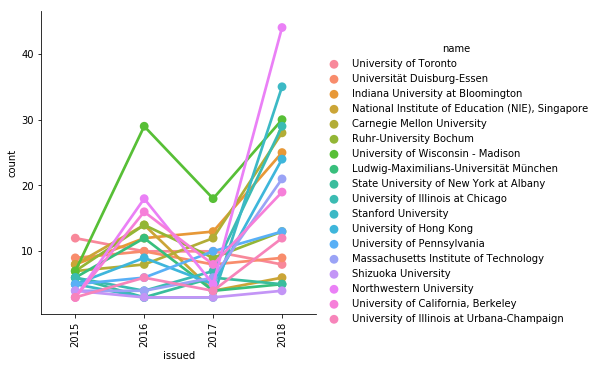

In [15]:
sns.catplot(data=ranks[ranks['name'].isin(all_) ], x='issued', y='count',kind='point', hue='name')
plt.xticks(rotation=90)
plt.show()

As 2018 saw an explosion of submissions overall, and is not a typical ICLS year, we do not further investigate this popularity difference between ICLS and CLCS for now.

### Plotting the difference on a map:

We put a dot whos size depends on the number of contributions on the map. blue: ICLS only inst.; orange: CSCL only inst.

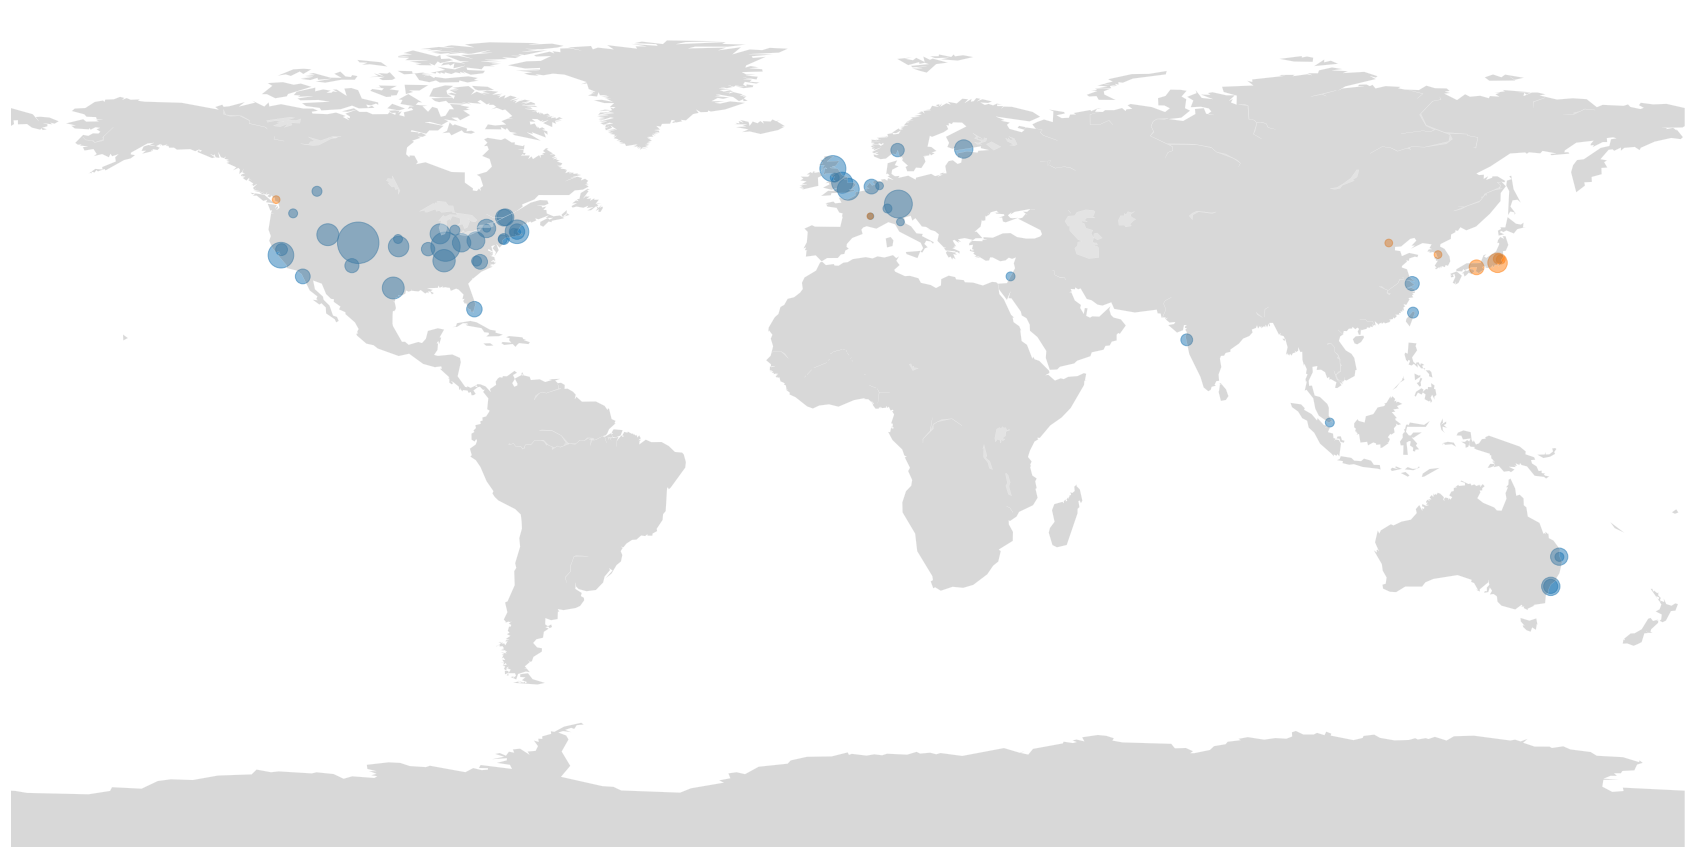

In [16]:
plt.figure(figsize=(30, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
# prepare a color for each point depending on the continent.
data = universities[universities.name.isin(ICLS)].copy()
 
# Add a point per position
m.scatter(data[~data.name.duplicated()]['Lon'], 
          data[~data.name.duplicated()]['Lat'], 
          s=data.name.value_counts()*20, 
          cmap=plt.cm.Set2, alpha=0.5)

data = universities[universities.name.isin(CSCL)].copy()
 
# Add a point per position
m.scatter(data[~data.name.duplicated()]['Lon'], 
          data[~data.name.duplicated()]['Lat'],
          s=data.name.value_counts()*20, 
          cmap=plt.cm.Set1, alpha=0.5)


The Orange dots are given by:

In [17]:
CSCL

{'Beijing Normal University',
 'Ecole Normale Supérieure de Lyon',
 'Educational Testing Service',
 'Hallym University',
 'Ibaraki University',
 'Kobe University',
 'Senshu University',
 'Simon Fraser University',
 'Utsunomiya University'}

## Universities participating every year:


We see that the universities participating every year form dense clusters of geographically close universities. 

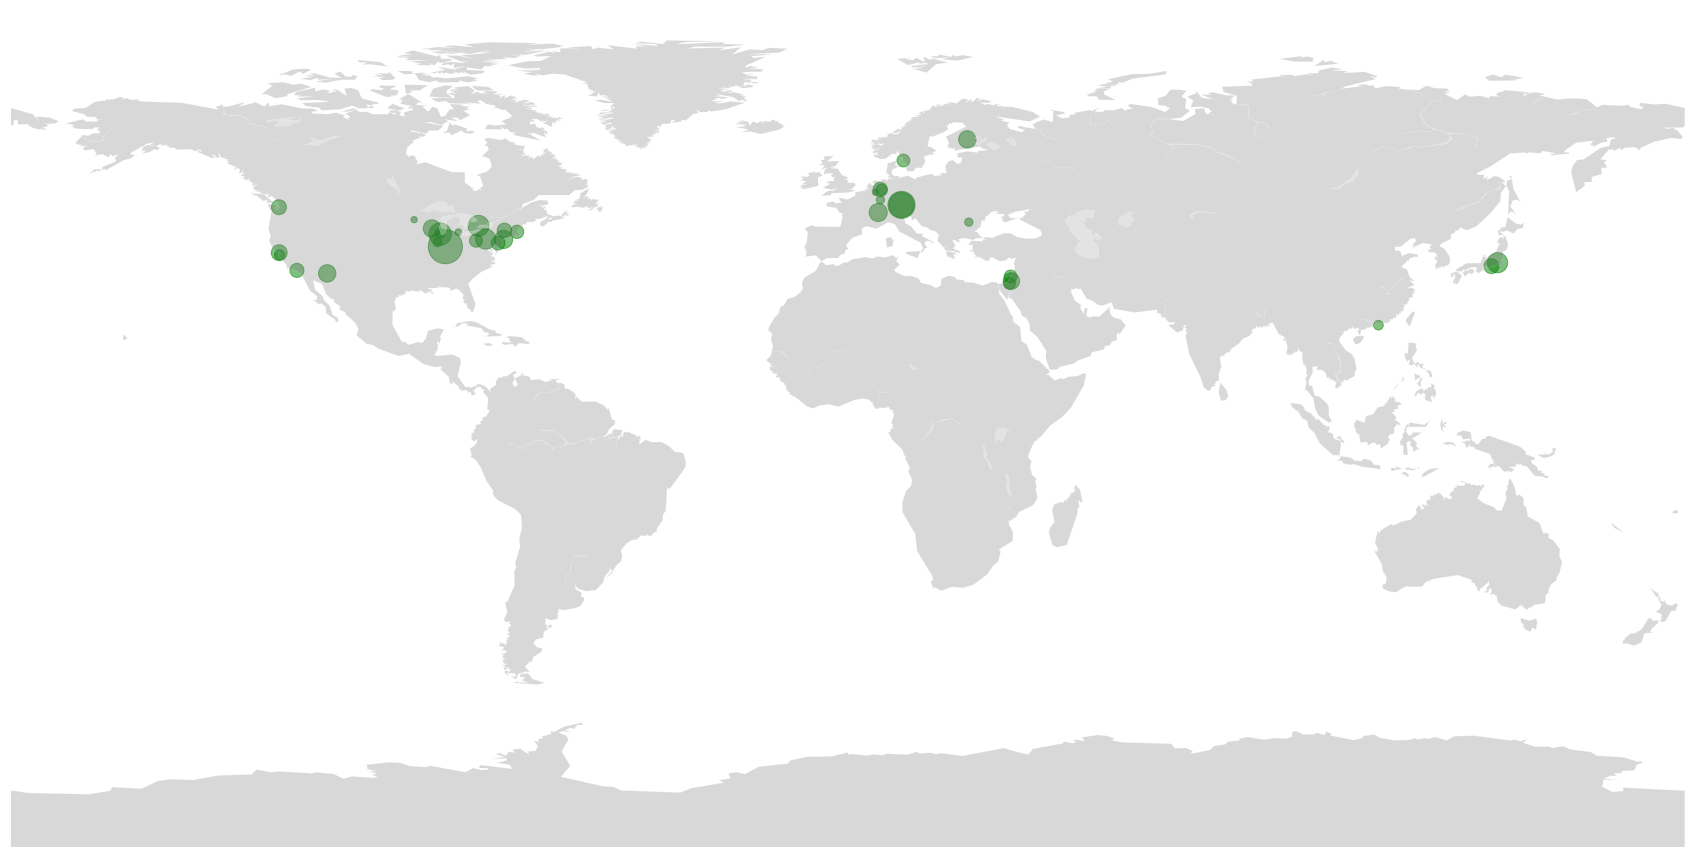

In [18]:
plt.figure(figsize=(30, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")

data = universities[universities.name.isin(all_years)].copy()
 
# Add a point per position
m.scatter(data[~data.name.duplicated()]['Lon'], 
          data[~data.name.duplicated()]['Lat'],
          s=data.name.value_counts()*5,
          c='green', alpha=0.5)

### Base analysis of Countries present in dataset:

We have an interessting result: **The increase in number of participants is mostly due to new participants from the U.S.A.**

In [19]:
uni_year = grouping.groupby('issued').apply(lambda x: set(x['country']))
years = uni_year.index.tolist()
unis = uni_year.tolist()
all_ = set()
[all_.update(x) for x in unis]

all_years = unis[0]
ICLS = all_
CSCL = all_


for i, x in enumerate(unis):
    all_years = all_years.intersection(x)

In [20]:
grouping =  associations.copy()
grouping = grouping[
                    #only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated()) & 
                    #only consider universities that participated every year
                    (grouping.country.isin(all_years))]


ranks = pd.DataFrame(grouping.groupby('issued').country.value_counts())
ranks.columns = ['count']
ranks.reset_index(inplace=True)

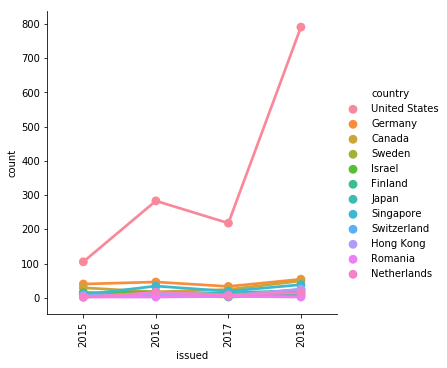

In [21]:
sns.catplot(data=ranks, x='issued', y='count',kind='point', hue='country')
plt.xticks(rotation=90)
plt.show()

Looking at it without america:

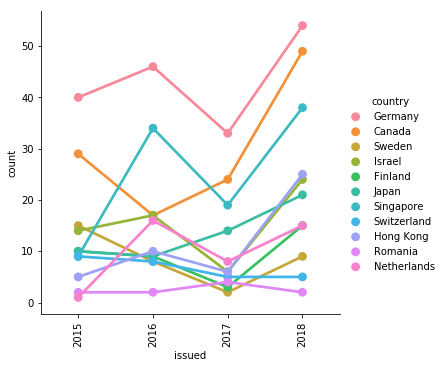

In [22]:
sns.catplot(data=ranks[(ranks.country != 'United States')], x='issued', y='count',kind='point', hue='country')
plt.xticks(rotation=90)
plt.show()

#### We now take an alternative view using stacked bar charts, to see evolution in percentage:

In [23]:
grouping =  associations.copy()
grouping = grouping[(grouping.name != 'gmail') & 
                    #only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated())]

In [24]:
viz = pd.DataFrame(grouping[['country', 'name', 'file', 'issued']].groupby(['issued', 'country']).name.value_counts())
viz.columns = ['counts']
viz.reset_index(inplace=True)

In [25]:
viz.head()

,issued,country,name,counts
0,2015,Australia,University of Sydney,11
1,2015,Canada,University of Toronto,12
2,2015,Canada,Simon Fraser University,6
3,2015,Canada,Dawson College,5
4,2015,Canada,John Abbott College,4


Set a colorbar to get more readable plot:

In [26]:
country_bar = pd.DataFrame(viz.groupby(['country', 'issued']).counts.sum()/viz.groupby(['issued']).counts.sum()*100).copy()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)
to_ignore = country_bar.loc[country_bar.counts < 1].country.unique()
country_bar.loc[country_bar.country.isin(to_ignore), 'country'] = 'Other'
country_bar = country_bar.groupby(['country', 'issued']).sum()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)

country_bar.head()

,country,issued,counts
0,Australia,2015,3.832753
1,Australia,2016,2.772277
2,Australia,2017,1.648352
3,Australia,2018,1.819757
4,Canada,2015,10.104530


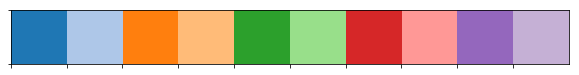

In [27]:
categories = country_bar.country.unique()
palette = sns.color_palette(palette='tab20', n_colors=len(categories)+1)

sns.palplot(palette)

We see that america makes up a bigger and bigger percentage

Text(0.5, 1.0, 'Participants by country (%)')

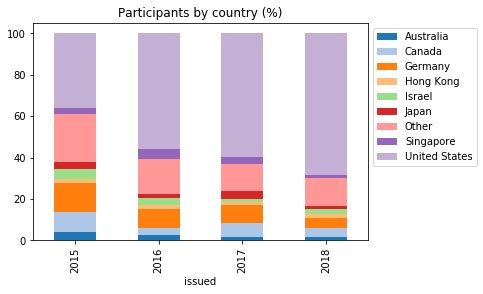

In [28]:
from matplotlib.colors import ListedColormap

country_bar = country_bar.pivot(index='issued', columns='country')
country_bar.columns = country_bar.columns.droplevel()

country_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Participants by country (%)')

In terms of absolute attendance, countries with less than 4 participants in any year are grouped into other to improve visibility:

Text(0.5, 1.0, 'Participants by country by conference')

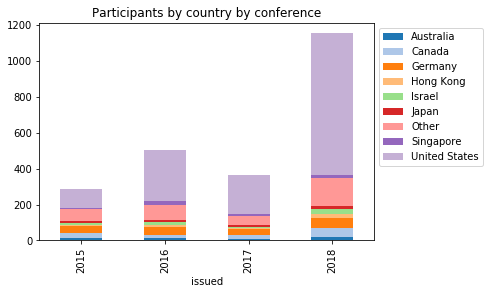

In [29]:
country_bar = pd.DataFrame(viz.groupby(['country', 'issued']).counts.sum()).copy()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)
country_bar.loc[country_bar.country.isin(to_ignore), 'country'] = 'Other'
country_bar = country_bar.groupby(['country', 'issued']).sum()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)

categories = country_bar.country.unique()
palette = sns.color_palette(palette='tab20', n_colors=len(categories)+1)

country_bar = country_bar.pivot(index='issued', columns='country')
country_bar.columns = country_bar.columns.droplevel()
country_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Participants by country by conference')

#### Going back to looking at universities: why does the U.S have this increase in participation?

From before we know that some universities have very large increase in conference participation, therefore we look at the increase in the U.S.A. more closely. We see that there are a lot more of authors from various universities contributing, which weren't contributing before.

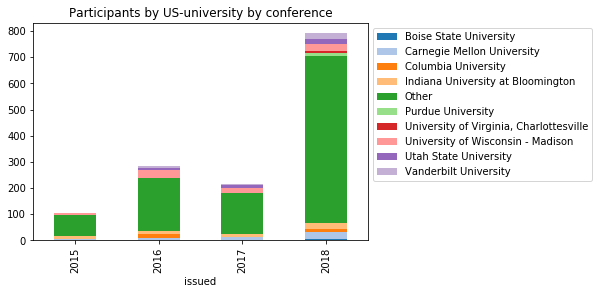

In [30]:
uni_bar = viz[viz.country == 'United States']
uni_bar = pd.DataFrame(uni_bar.groupby(['name', 'issued']).counts.sum()).copy()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)

#universities to be grouped as other for better plotting
candidate = uni_bar.groupby('name').counts.min() > 5
to_ignore = candidate[candidate == False].index.tolist()


uni_bar.loc[uni_bar.name.isin(to_ignore), 'name'] = 'Other'
uni_bar = uni_bar.groupby(['name', 'issued']).sum()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)

uni_bar = uni_bar.pivot(index='issued', columns='name')
uni_bar.columns = uni_bar.columns.droplevel()

#set palette to have unique color for every label
palette = sns.color_palette(palette='tab20', n_colors=uni_bar.T.shape[0])

uni_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))

plt.legend(bbox_to_anchor=(1, 1))
_ = plt.title('Participants by US-university by conference')

We look at the same graph with percentages, and see that the overall percentage of non major contributing institutions does not seem to change significantly over the years, hence the increase is not only due to new participants joining in !

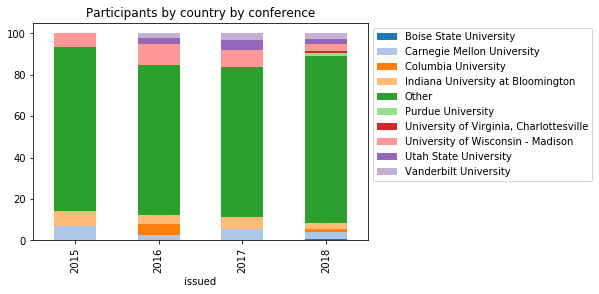

In [31]:
uni_bar = viz[viz.country == 'United States']
uni_bar = pd.DataFrame(uni_bar.groupby(['name', 'issued']).counts.sum()/uni_bar.groupby(['issued']).counts.sum()*100).copy()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)
uni_bar.loc[uni_bar.name.isin(to_ignore), 'name'] = 'Other'
uni_bar = uni_bar.groupby(['name', 'issued']).sum()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)

uni_bar = uni_bar.pivot(index='issued', columns='name')
uni_bar.columns = uni_bar.columns.droplevel()
uni_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))

plt.legend(bbox_to_anchor=(1, 1))
_ = plt.title('Participants by country by conference')

Looking at this more closely we break up the set in previous and new participants:

In [32]:
uni_bar = viz[viz.country == 'United States']
unis_per_year = uni_bar.groupby('issued').name.unique()
unis_per_year.map(len)

issued
2015     29
2016     55
2017     44
2018    121
Name: name, dtype: int64

Clearly the number of universities participating has almost doubeled!

In [33]:
set_prev_participants = set()
_ = unis_per_year[unis_per_year.index.isin([2015, 2016, 2017])].map(lambda x: set_prev_participants.update(x))

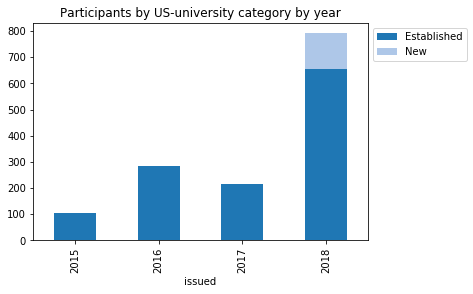

In [34]:
uni_bar = viz[viz.country == 'United States']
uni_bar = pd.DataFrame(uni_bar.groupby(['name', 'issued']).counts.sum()).copy()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)


uni_bar.loc[~uni_bar.name.isin(set_prev_participants), 'name'] = 'New'
uni_bar.loc[uni_bar.name.isin(set_prev_participants), 'name'] = 'Established'
uni_bar = uni_bar.groupby(['name', 'issued']).sum()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)

uni_bar = uni_bar.pivot(index='issued', columns='name')
uni_bar.columns = uni_bar.columns.droplevel()

#set palette to have unique color for every label
palette = sns.color_palette(palette='tab20', n_colors=uni_bar.T.shape[0])

uni_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))

plt.legend(bbox_to_anchor=(1, 1))
_ = plt.title('Participants by US-university category by year')

In [35]:
uni_bar

name,Established,New
issued,,
2015,104.0,NaN
2016,283.0,NaN
2017,217.0,NaN
2018,656.0,135.0


From the above graph we can see that many people from inst. that did not previously participate have participated in 2018, the do not account for all of the increase we see in 2018. Inst. that did participate in previous years also sent more people!

We see that a rise of about 200 can be attributed to participants from previously nonrepresented inst. 
This leaves about 300 extra people from inst. that participated in previous years. 

We try to see if we can attribute this to certain universities:

In [36]:
def above_mean_participation(x):
    """returns wether a university is participating more in 2018 than before"""
    return (x[x.issued == 2018].counts > x[x.issued != 2018].counts.median()+x[x.issued != 2018].counts.std())

def account_for(x):
    """Returns number of extra people sent in 2018, as a base participation 
    we take either the median or number of participants in 2016"""

    return x[x.issued == 2018
            ].counts.item() - max(x[x.issued != 2018].counts.median().item(), x[x.issued == 2016].counts.item())

Here we get the universities that seen to have a large increase in participation:

In [37]:
uni_bar = viz[viz.name.isin(set_prev_participants)]
uni_bar.reset_index(inplace=True)
increased_particip = uni_bar.groupby('name').apply(above_mean_participation)
increased_particip = increased_particip[increased_particip == True].reset_index().name.tolist()
increased_particip

['Arizona State University',
 'Carnegie Mellon University',
 'Harvard University',
 'Indiana University at Bloomington',
 'Massachusetts Institute of Technology',
 'New York University',
 'Northwestern University',
 'Rutgers University, Newark',
 'Stanford University',
 'Tufts University',
 'University of California, Berkeley',
 'University of California, Davis',
 'University of California, Los Angeles',
 'University of Colorado at Boulder',
 'University of Illinois at Chicago',
 'University of Illinois at Urbana-Champaign',
 'University of Maryland, College Park',
 'University of Michigan - Ann Arbor',
 'University of Minnesota - Twin Cities',
 'University of Pennsylvania',
 'University of Texas at Austin',
 'University of Washington',
 'University of Wisconsin - Madison',
 'Utah State University',
 'Vanderbilt University']

In [38]:
increase = uni_bar[uni_bar.name.isin(increased_particip)].groupby('name').apply(account_for).reset_index()
increase.sort_values(by=0, ascending=False)

,name,0
8,Stanford University,32.0
6,Northwestern University,26.0
14,University of Illinois at Chicago,23.0
13,University of Colorado at Boulder,20.0
1,Carnegie Mellon University,20.0
0,Arizona State University,17.0
17,University of Michigan - Ann Arbor,17.0
4,Massachusetts Institute of Technology,17.0
24,Vanderbilt University,16.5
12,"University of California, Los Angeles",14.0


In [39]:
increase[0].sum()

300.0

We see that the extra participants from these universities would account for the around 300 extra people, giving more comprehensive view of what happend in 2018. 
1. more participants from previously not attending universities attened
2. certain universities sent a lot more people to attend

We will later use the graphs of coauthors to get even more insight into how these new people participated. Did they collaborate with somebody that was already present in previous years?

### Generalize this over the years:

How many participants from the previous years are participating again?
How many participants are first year participants that year?

In [40]:
participants_year = dict()
for year in associations.issued.unique():
    participants_year[year] =  set(associations[associations.issued == year].long_name.tolist())

In [41]:
participants_year[2018] = participants_year[2018]-(participants_year[2017].union(
    participants_year[2016].union(participants_year[2015])))
participants_year[2017] = participants_year[2017]-participants_year[2016].union(participants_year[2015])
participants_year[2016] = participants_year[2016]-participants_year[2015]

In [42]:
prev_year = pd.DataFrame(associations[associations.long_name.isin(participants_year[2015])].groupby(
    ['issued']).long_name.unique().map(len)).rename(columns={'long_name': '2015'})
prev_year

,2015
issued,
2015,290
2016,95
2017,81
2018,96


In [43]:
prev_year['2016'] = associations[associations.long_name.isin(participants_year[2016])].groupby(['issued']
                                ).long_name.unique().map(len)
prev_year['2017'] = associations[associations.long_name.isin(participants_year[2017])].groupby(['issued']
                                ).long_name.unique().map(len)
prev_year['2018'] = associations[associations.long_name.isin(participants_year[2018])].groupby(['issued']
                                ).long_name.unique().map(len)

In [44]:
palette = sns.color_palette(palette='tab20', n_colors=4)

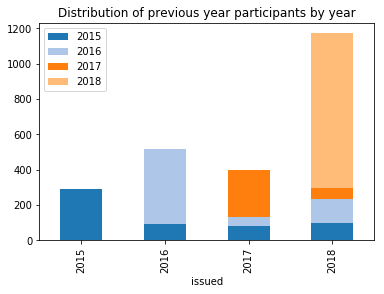

In [45]:
prev_year.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))
_ = plt.title('Distribution of previous year participants by year')

We see that each year, a good portion of the conference is from new participants.

In [46]:
(prev_year.T/prev_year.T.sum()).T

,2015,2016,2017,2018
issued,,,,
2015,1.000000,NaN,NaN,NaN
2016,0.183398,0.816602,NaN,NaN
2017,0.203008,0.130326,0.666667,NaN
2018,0.081911,0.119454,0.052901,0.745734


Text(0, 0.5, '% of participants')

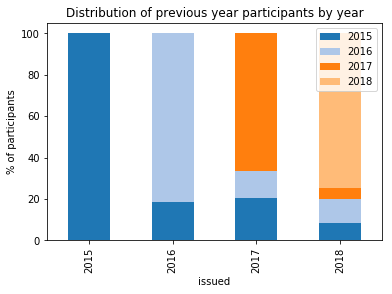

In [47]:
(prev_year.T/prev_year.T.sum()*100).T.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))
_ = plt.title('Distribution of previous year participants by year')
plt.ylabel('% of participants')

# Looking at where people collaborate:

## Building a collaboration graph, only taking into consideration countries:

We use the author index to match up author names with indices:

In [48]:
pub_collab = associations[['file','country', 'name']].drop_duplicates()
collabs = pd.merge(pub_collab, pub_collab, on='file').drop_duplicates()
collabs.dropna(inplace=True)
collabs.head()

,file,country_x,name_x,country_y,name_y
0,import2018_371,United States,University of Colorado at Boulder,United States,University of Colorado at Boulder
1,import2018_417,United States,Indiana University at Bloomington,United States,Indiana University at Bloomington
2,import2018_417,United States,Indiana University at Bloomington,United States,Indiana University
3,import2018_417,United States,Indiana University,United States,Indiana University at Bloomington
4,import2018_417,United States,Indiana University,United States,Indiana University


In [49]:
collabs['issued'] = collabs.file.map(lambda x: int(reg.search('20[\d]{2}', x).group(0)))

Building collaboration graph:

In [50]:
nodes = pd.DataFrame(collabs.country_x.dropna().unique())
nodes.columns = ['country']
nodes.reset_index(inplace=True)
nodes.head()

,index,country
0,0,United States
1,1,Germany
2,2,United Kingdom
3,3,Singapore
4,4,Canada


In [51]:
country_index = nodes.country.to_dict()
country_index = {v: k for k, v in country_index.items()}

collabs['source'] = collabs.country_x.map(country_index)
collabs['target'] = collabs.country_y.map(country_index)

In [52]:
def get_adjacency(nodes, edges):
    n_nodes = len(nodes)
    adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

    for idx, row in edges.iterrows():
        i, j = int(row.source), int(row.target)
        adjacency[i, j] += 1
        adjacency[j, i] = adjacency[i, j]


    return adjacency

In [53]:
adjacency = get_adjacency(nodes, collabs)

In [54]:
n_nodes = len(nodes)
graph = nx.from_numpy_array(adjacency - np.identity(n_nodes)*adjacency)
mapping = nodes.country.to_dict()

## Most collaborative countries

The number represented is: number of different papers written in collaboration with an other country.
Clearly, as the owerall number of papers for the us is extremly hight, the US will dominate this graph:

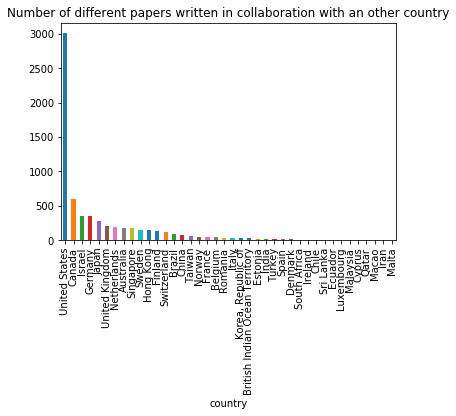

In [55]:
nodes['degrees'] = pd.Series(adjacency.sum(axis=1))
plt.title('Number of different papers written in collaboration with an other country')
nodes.set_index('country').degrees.sort_values(ascending=False).plot(kind='bar')

What country has most collaborations with different countries?
That the number on the y axis is the number of countries the country on the x axis collaborates with: 

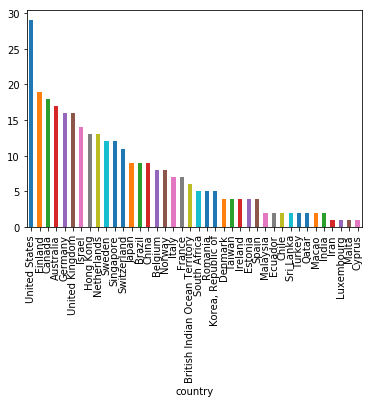

In [56]:
nodes['degrees'] = pd.Series(np.where(adjacency > 0, 1, 0).sum(axis=1))
nodes.set_index('country').degrees.sort_values(ascending=False).plot(kind='bar')

## Isolated Countries

In [57]:
zero_collabs = np.where((adjacency - adjacency*np.identity(n_nodes)).sum(axis=1) == 0)
nodes.iloc[zero_collabs]

,index,country,degrees
21,21,Iran,1
27,27,Luxembourg,1
28,28,Malta,1
36,36,Cyprus,1


## Looking at the countries that do collaborate:

The total number of connected components (including isolated nodes) is:

In [58]:
nx.number_connected_components(graph)

5

**Hence all other countries are part of the main component.**

To more easely visualize the graph we extract the largest component and try to partition/cluster the graph in some way. Here we use the kernighan lin bisection algorithm to find a bisection. The bisection groupy the countries into countries with a lot of collaboration and little collaboration.

In [59]:
components = nx.connected_components(graph)
largest_cc = max(nx.connected_components(graph), key=len)
graph = graph.subgraph(largest_cc)

#remove countries not in largest component
mapping = {k:mapping[k] for k in largest_cc if k in mapping}

In [60]:
from networkx.algorithms.community import kernighan_lin_bisection
c = list(kernighan_lin_bisection(graph))

In [61]:
def matching_by_criteria(c):
    member_label = {}
    for index, community in enumerate(c):
        members = list(community)
        for m in members:
            member_label[m] = index
    return member_label

country_partition = matching_by_criteria(c)

Change size of nodes based on with how many other countries a country interacts:

We use degree centrality, which will be large for countries with a lot of collaboration and small for countries with little collaboration.

In [62]:
node_size = (np.array(list(nx.degree_centrality(graph).values())))*1500
edge_color= np.array(list(nx.get_edge_attributes(graph, 'weight').values()))

Unify color palette using the following code:

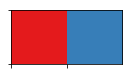

In [63]:
palette = sns.color_palette(palette='Set1', n_colors=2)
sns.palplot(palette)

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


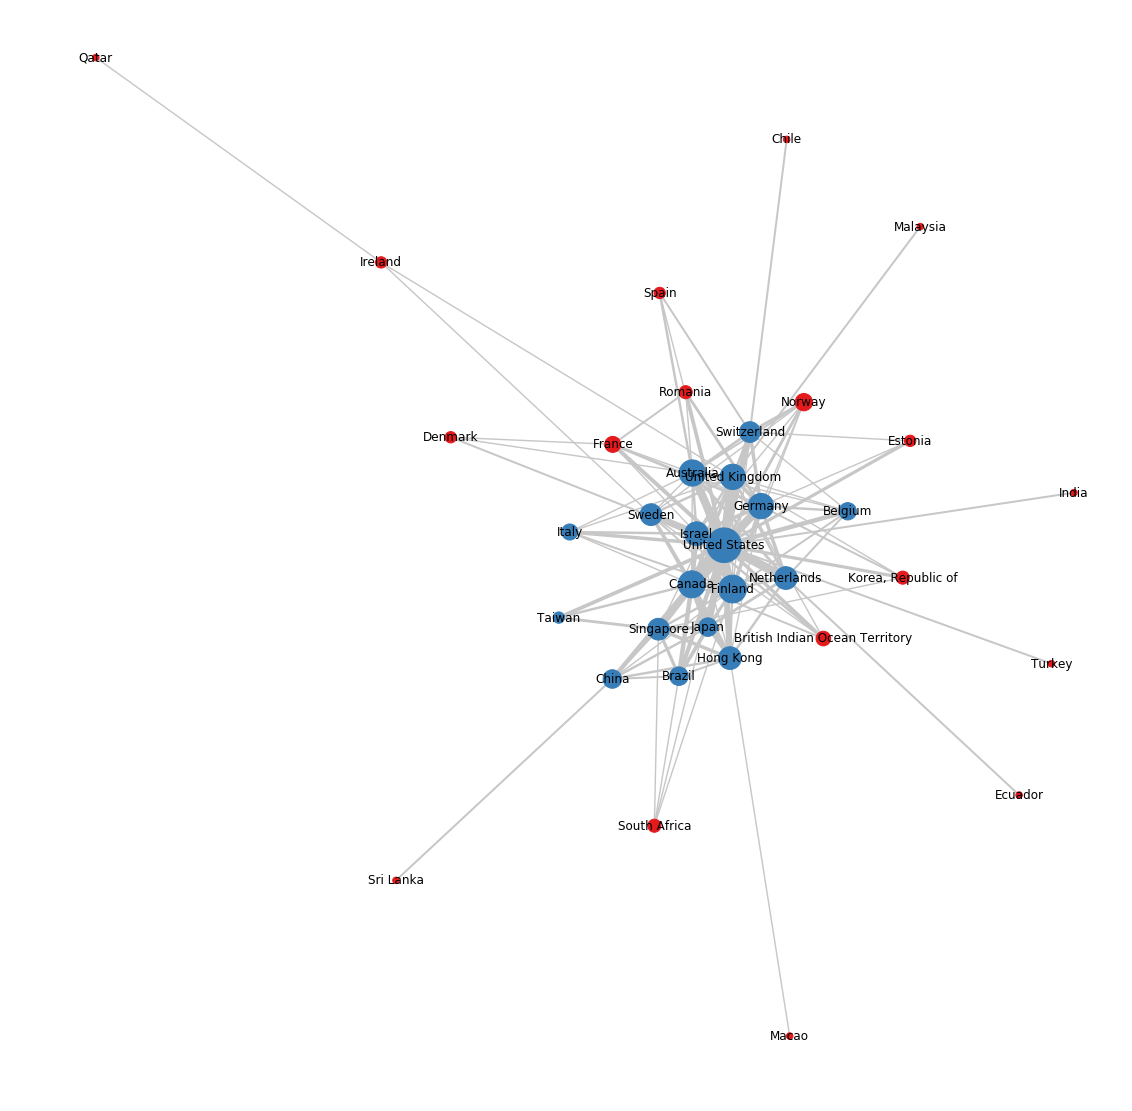

In [64]:
plt.figure(figsize=(15, 15))
nx.draw_spring(graph, 
               edge_color='#C7C7C7', 
               node_color=pd.Series(country_partition).sort_index().tolist(),
               width = np.sqrt(edge_color),
               #edge_color = np.sqrt(edge_color),
               edge_cmap = plt.cm.gray_r,
               cmap=ListedColormap(palette.as_hex()), 
               node_size=node_size, 
               labels=mapping)

We see that we have a hub in which countries collaborate strongly within each other, and to which less collaborative countries connect to, giving us a star-like structure.

An alternative visualization for the graph using the adjacency matrix. In the below picture, a black dot represents a connection between the countries listed on the x, resp. y axis. It can give us a direct look at the overall community structure, again showing that we have a group of regulars in the center, with less collaborative countries at the fringes.

In [65]:
reordering = [ j for j, i in country_partition.items()]

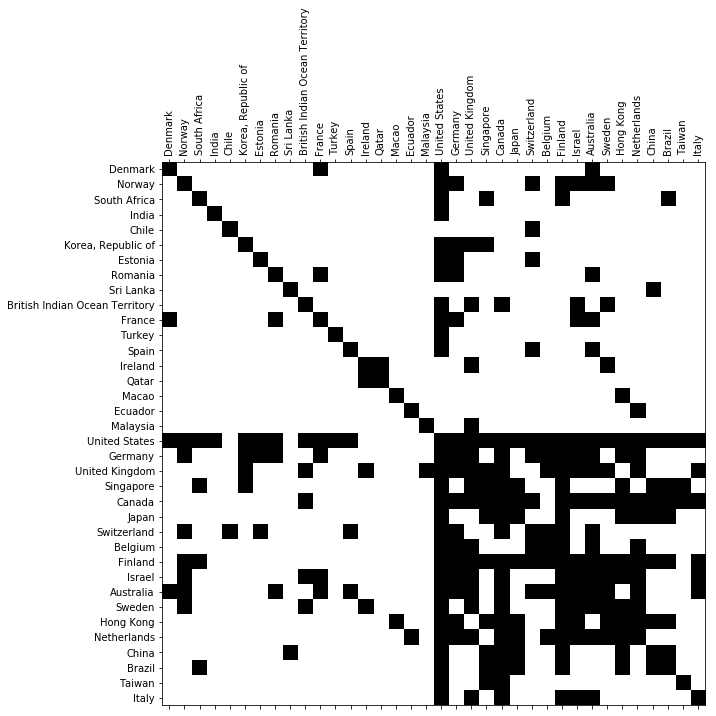

In [66]:
plt.figure(figsize=(10, 10))
plt.spy(adjacency[reordering][:, reordering])
plt.xticks(np.arange(nodes.shape[0]-4), nodes.country.iloc[reordering], rotation=90)
_ = plt.yticks(np.arange(nodes.shape[0]-4), nodes.country.iloc[reordering])

Same but with weigthed edges indicating the strength of collaboration:

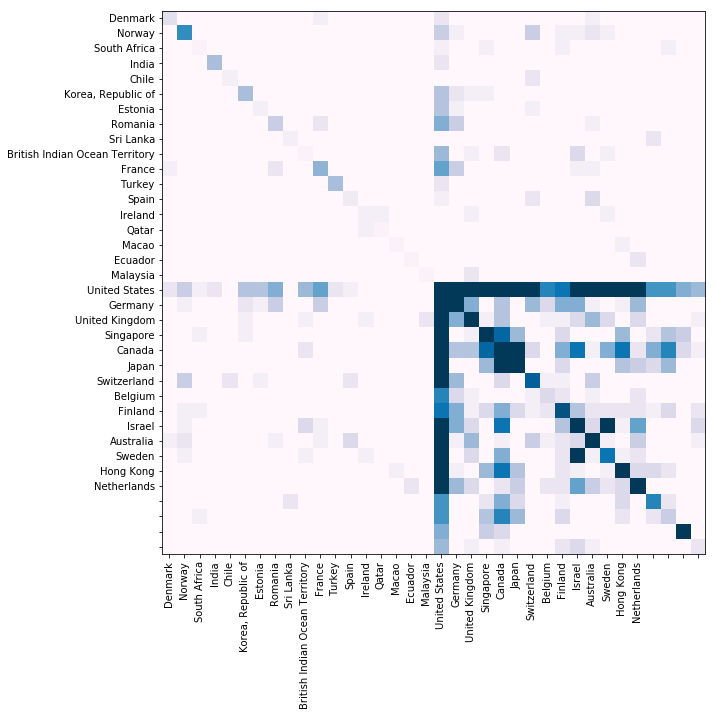

In [67]:
plt.figure(figsize=(10, 10))
plt.imshow(adjacency[reordering][:, reordering], vmin=0, vmax=30, cmap=plt.cm.PuBu)
plt.xticks(np.arange(nodes.shape[0]-4), nodes.iloc[reordering].country.iloc[:-4], rotation=90)
_ = plt.yticks(np.arange(nodes.shape[0]-4), nodes.iloc[reordering].country.iloc[:-4])

### Changes from year to year:

We build the collaboration graph to see if there are any changes and what the changes are:

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


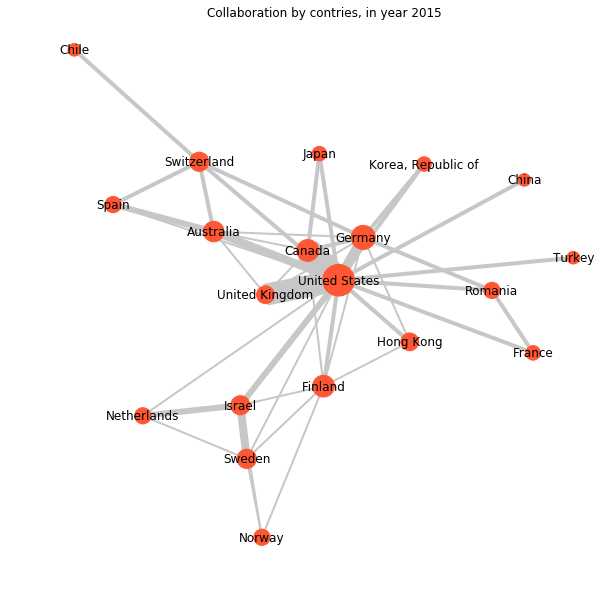

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


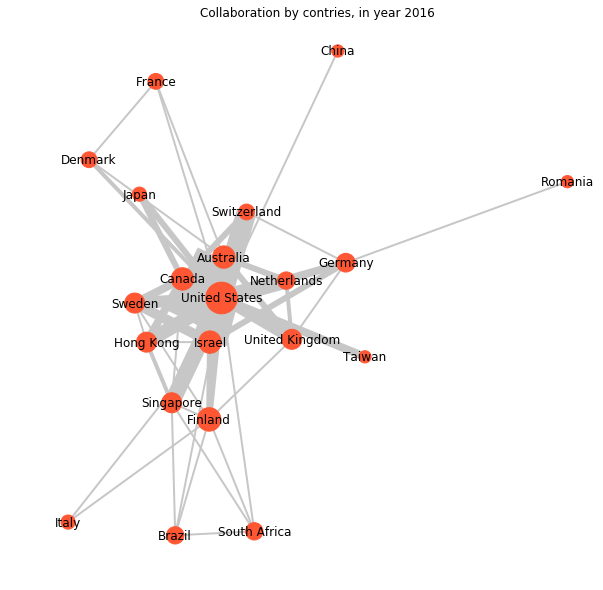

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


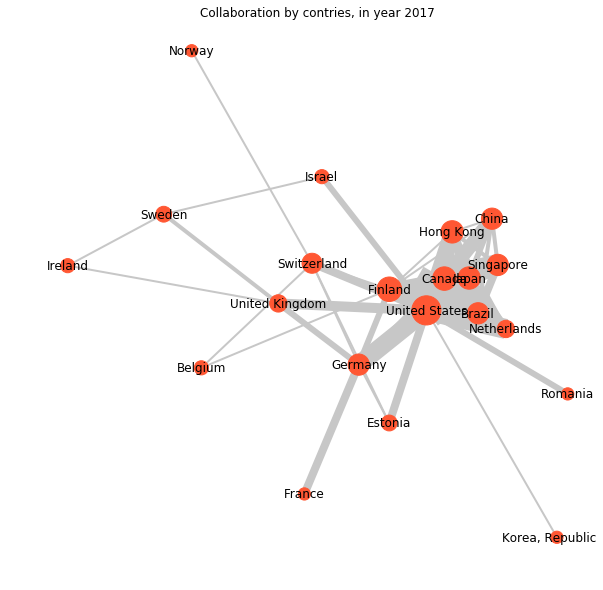

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


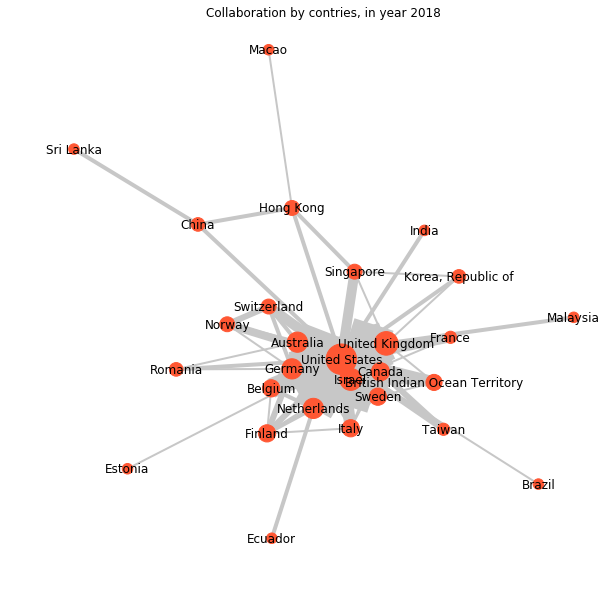

In [68]:
for year in sorted(collabs.issued.unique()):

    year_adjacency = get_adjacency(nodes, collabs[collabs.issued == year])
    graph_year = nx.from_numpy_array(year_adjacency)

    nx.set_node_attributes(graph_year, nodes.country.to_dict(), name='Country')

    largest_cc = max(nx.connected_components(graph_year), key=len)
    graph_year = graph_year.subgraph(largest_cc)
    
    mapping = nx.get_node_attributes(graph_year, 'Country')
    node_size = (np.array(list(nx.degree_centrality(graph_year).values())))*1000
    edge_color= np.array(list(nx.get_edge_attributes(graph_year, 'weight').values()))

    plt.figure(figsize=(10, 10))
    
    plt.title(f'Collaboration by contries, in year {year}')
    nx.draw_spring(graph_year, 
                   edge_color='#C7C7C7', 
                   node_color='#FF5733',
                   width = edge_color,
                   #edge_color = np.log(edge_color),
                   #edge_cmap = plt.cm.gray_r,
                   cmap=ListedColormap(palette.as_hex()), 
                   node_size=node_size, 
                   labels=mapping
                  )
    plt.show()

# Looking at collaborating between universities:

Find who collaborated with whom on a paper and turn the resulting edge list into a graph:

In [69]:
pub_collab = associations[['file','name', 'country', 'Lon', 'Lat']].drop_duplicates().dropna()
pub_collab = pub_collab[pub_collab.name != 'gmail']
collabs = pd.merge(pub_collab, pub_collab, on='file').drop_duplicates()

#collabs = collabs[collabs.name_x != collabs.name_y]

nodes = pd.DataFrame(collabs.name_x.dropna().unique())
nodes.columns = ['name']
nodes.reset_index(inplace=True)

In [70]:
uni_index = nodes.name.to_dict()
uni_index = {v: k for k, v in uni_index.items()}

collabs['source'] = collabs.name_x.map(uni_index)
collabs['target'] = collabs.name_y.map(uni_index)

In [71]:
adjacency = get_adjacency(nodes, collabs)
n_nodes = len(nodes)
graph = nx.from_numpy_array(adjacency - np.identity(n_nodes)*adjacency)

### Most collaborative universities:

Again we answer basic quantitative questions about the number of collaborations:

**Number of different papers written in collaboration with an other university.**

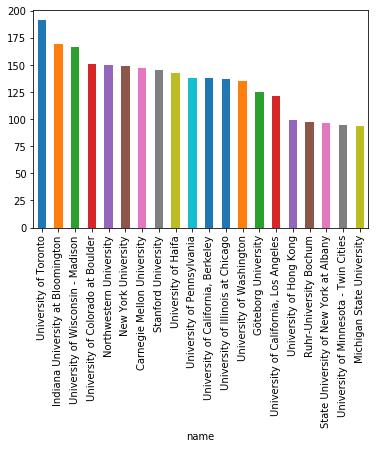

In [72]:
nodes['degrees'] = pd.Series(adjacency.sum(axis=1))
nodes.set_index('name').degrees.sort_values(ascending=False).head(20).plot(kind='bar')

Number of distinct different institution collbaorations:
The number on the y axis is the number of different institutions a university collaborated with (without counting how often the did this.)

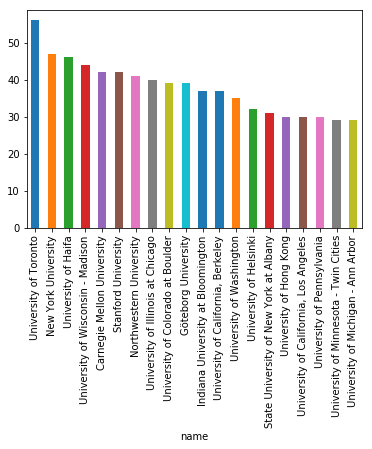

In [73]:
nodes['degrees'] = pd.Series(np.where(adjacency > 0, 1, 0).sum(axis=1))
nodes.set_index('name').degrees.sort_values(ascending=False).head(20).plot(kind='bar')

## Isolated universities:

Analyzing Universities that have not collaborated with other universities:

In [74]:
zero_collabs = np.where((adjacency - adjacency*np.identity(n_nodes)).sum(axis=1) == 0)
zero_collabs[0].shape

(39,)

In [75]:
country_uni_df =  pd.merge(nodes, universities, on='name', how='left'
                          )[['name', 'country', 'degrees', 'index']].drop_duplicates()

country_uni_df[country_uni_df['index'].isin(zero_collabs[0])]

,name,country,degrees,index
1241,Aarhus University,Denmark,1,38
1847,Brandeis University,United States,1,65
2019,University of Massachusetts at Amherst,United States,1,72
2259,University of Bergen,Norway,1,82
2387,"Aalborg University, Denmark",Denmark,1,91
2479,University of Missouri - Columbia,United States,1,100
2488,Oklahoma State University,United States,1,101
2492,Harding University,United States,1,103
2530,Tarbiat Modares University,Iran,1,109
2531,Stockholm University,Sweden,1,110


Looking at what countries these universities are in:

In [76]:
country_uni_df[country_uni_df['index'].isin(zero_collabs[0])].country.value_counts()

United States         21
Korea, Republic of     3
Sweden                 2
United Kingdom         2
Denmark                2
Cyprus                 1
Netherlands            1
Singapore              1
Norway                 1
Iran                   1
Turkey                 1
Malta                  1
Switzerland            1
Belgium                1
Name: country, dtype: int64

## Analyzing main group of universities interacting:

We only look at largest component and ignore universities that don't belong to the main cluster

In [77]:
components = nx.connected_components(graph)
largest_cc = max(components, key=len)

main_universities = graph.subgraph(largest_cc)

Number of components of universities that collaborate outside of main cluster:

In [78]:
nx.number_connected_components(graph) - zero_collabs[0].shape[0]-1

6

We look at the smaller connected components with at least 3 nodes:

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


163            Shandong University
164     Liaoning Normal University
165    National Science Foundation
Name: name, dtype: object


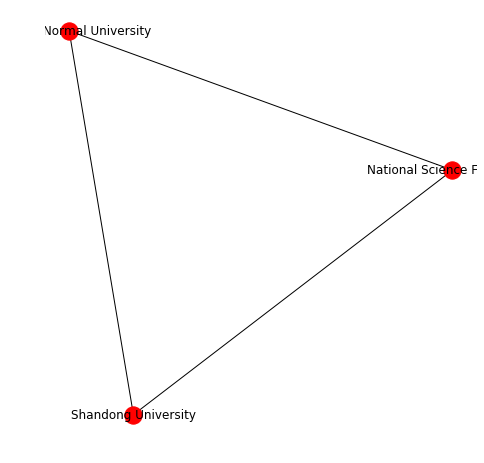

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


219    Illinois State University
220       Wake Forest University
221    Missouri State University
Name: name, dtype: object


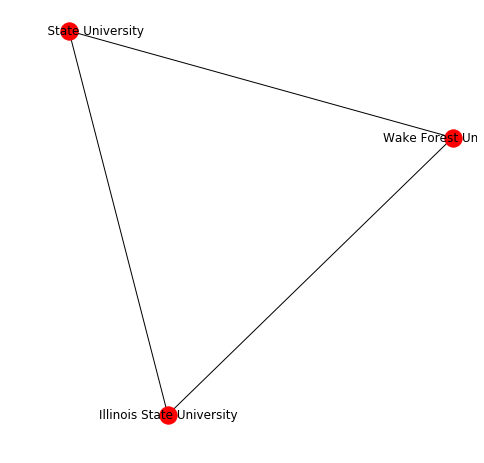

In [79]:
for g in list(nx.connected_component_subgraphs(graph)):
   
    if len(g.nodes) > 2 and len(g.nodes) < len(largest_cc):
        plt.figure(figsize=(6, 6))
        nx.draw_spring(g, labels=nodes.iloc[list(g.nodes)].name.to_dict())
        print(nodes.iloc[list(g.nodes)].name)
        plt.show()

### Main component

We partition the nodes to find "communities" of universities. They are the colored with the same color

In [80]:
from networkx.algorithms.community import greedy_modularity_communities
partition = list(greedy_modularity_communities(main_universities))
uni_partition = matching_by_criteria(partition)

Our partitioning algorthims finds 14 communities:

In [81]:
len(partition)

12

Change size of nodes based on with how many other countries a country interacts: the more connections the other nodes it has the larger the node will be.


For readability only nodes with some of the largest values –universities who are at the center of collaboration– are labeled. 

In [82]:
node_size = np.array(list(nx.degree_centrality(main_universities).values()))
edge_width = np.array(list(nx.get_edge_attributes(main_universities, 'weight').values()))

In [83]:
np.sqrt(edge_width).max()

4.69041575982343

In [84]:
nodes.loc[list(largest_cc),'node_size'] = node_size
labels = nodes.iloc[list(largest_cc)][nodes.node_size > np.percentile(node_size, 97.5)].name

/anaconda3/envs/Biblio/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


The color pallete for each cluster corresponds to the following cluster number:

   1  ||  2  ||  3  ||  4  ||  5  ||  6  ||  7  ||  8  ||  9  ||  10  ||  11  ||  12


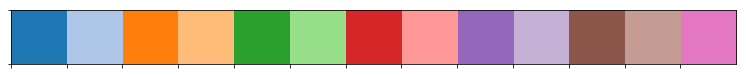

In [85]:
palette = sns.color_palette(palette='tab20', n_colors=len(partition)+1)

sns.palplot(palette)
print('  ', '  ||  '.join([str(i) for i in list(range(1,len(partition)+1))]))

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


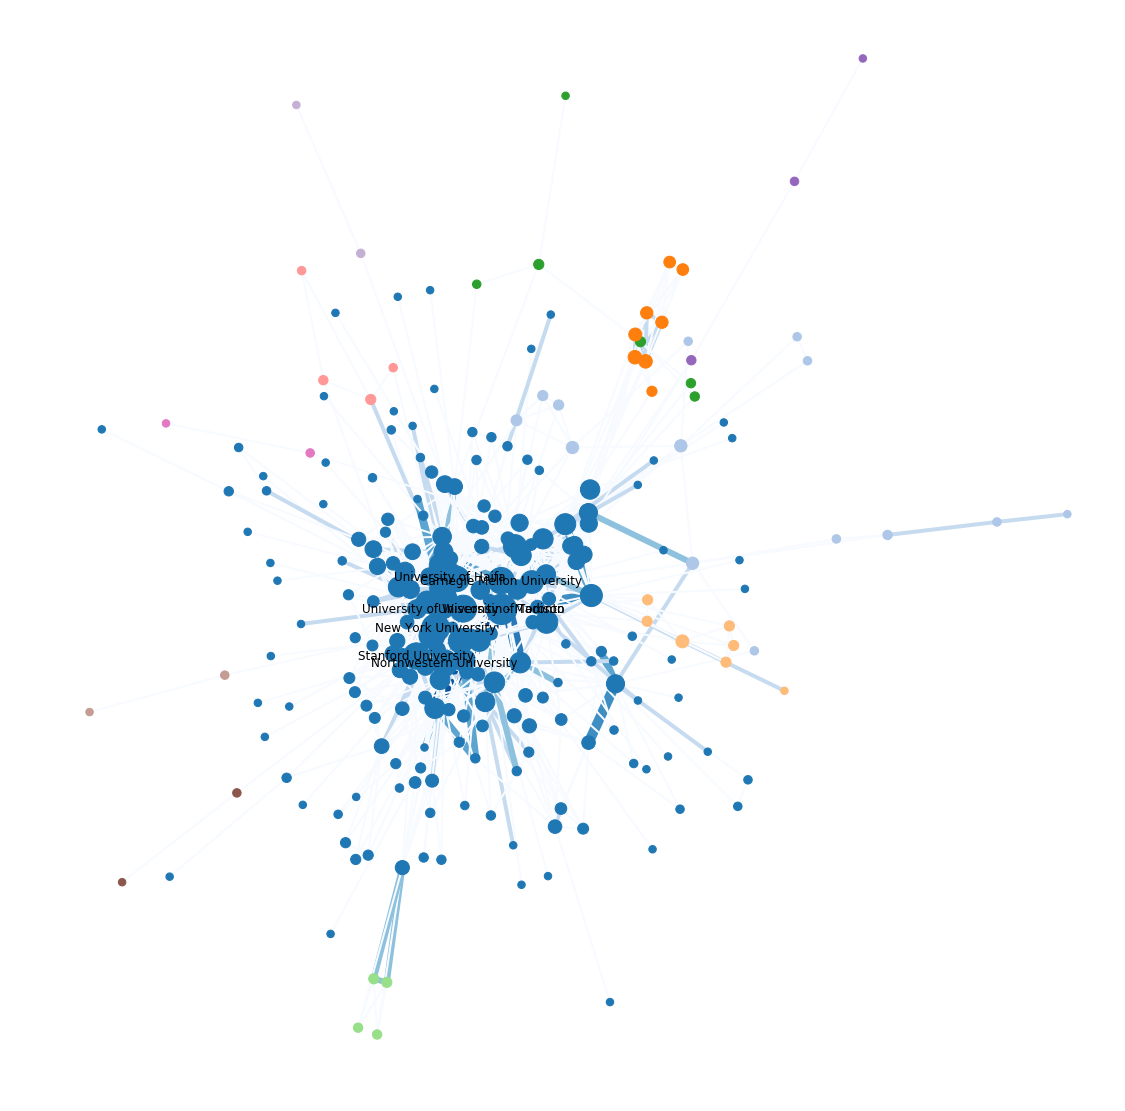

In [86]:
plt.figure(figsize=(15, 15))
nx.draw_spring(main_universities,  #edge_color='grey', 
               node_color=pd.Series(uni_partition).sort_index().tolist(),
               width = edge_width,
               edge_color = np.log(edge_width+1),
               edge_cmap = plt.cm.Blues,
               cmap=ListedColormap(palette.as_hex()), 
               node_size=(node_size+0.01)*4000, 
               labels=labels,
               iterations=5000
              )

In [87]:
G = nx.k_core(main_universities, 10)

In [88]:
len(G.nodes)

57

In [89]:
node_colors = pd.Series(uni_partition)[list(G.nodes())].sort_index().tolist()
node_size = np.array(list(nx.betweenness_centrality(G).values()))

In [90]:
uni = nodes.iloc[list(G.nodes())].name

In [91]:
uni_of_interest = pd.DataFrame(uni[list(G.nodes())]).copy()
uni_of_interest['centrality'] = node_size

In [92]:
uni_of_interest.centrality.quantile(.95)

0.03907609367556909

In [93]:
labels = uni_of_interest[uni_of_interest.centrality > uni_of_interest.centrality.quantile(.70)]
labels = labels['name']
labels = labels.to_dict()

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


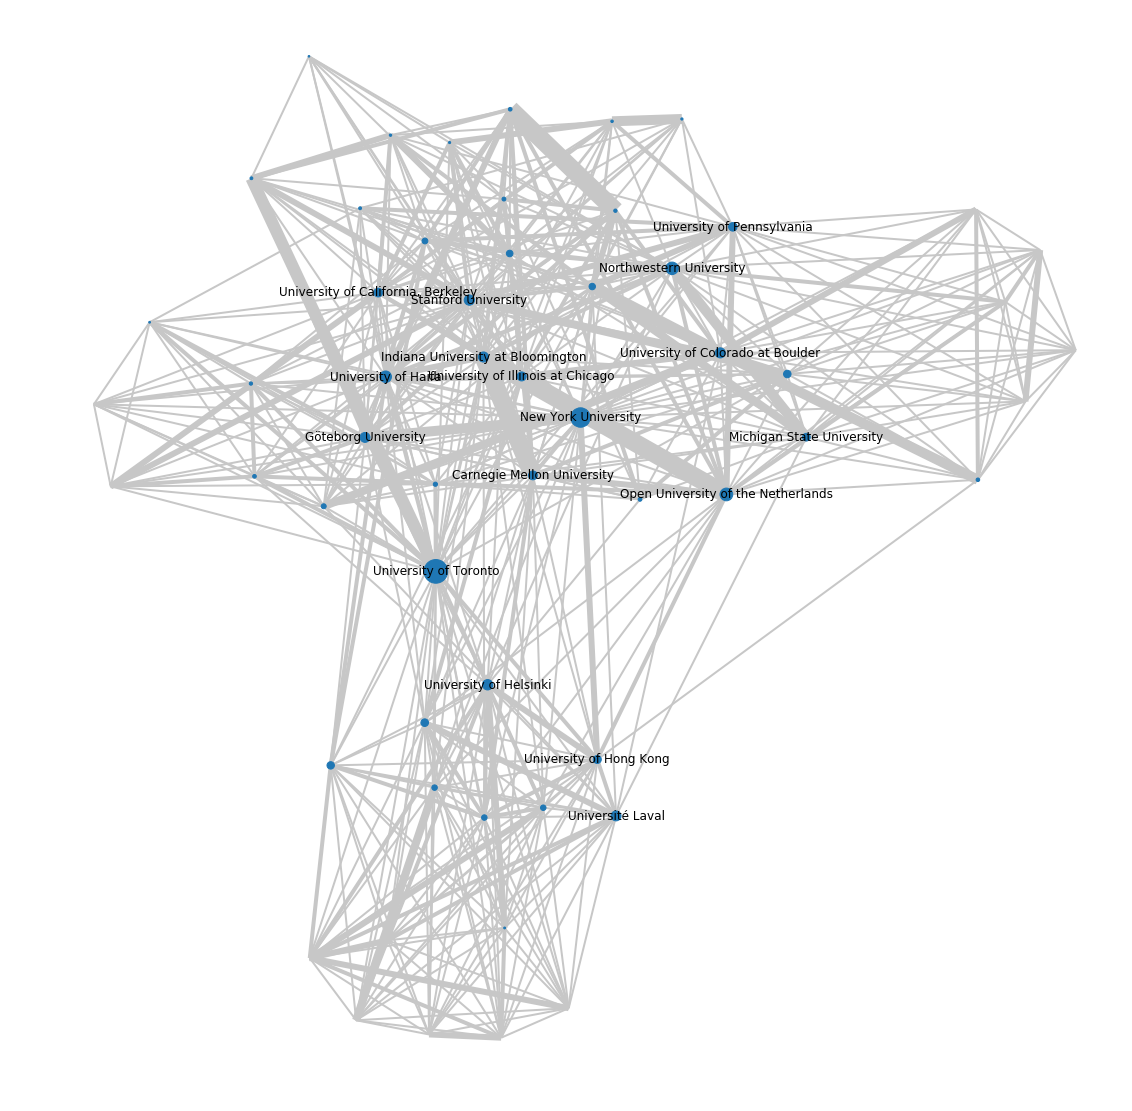

In [94]:
plt.figure(figsize=(15, 15))
nx.draw_spring(G,  edge_color='#C7C7C7', 
               node_color=pd.Series(uni_partition)[list(G.nodes())].sort_index().tolist(),
               width = edge_width,
               #edge_color = np.log(edge_width+1),
               edge_cmap = plt.cm.Blues,
               cmap=ListedColormap(palette.as_hex()), 
               node_size=node_size*4000, 
               labels=labels,
               iterations=5000
              )

In [95]:
nodes[['Lon', 'Lat']] = pd.merge(nodes, universities, on='name', 
                  how='left')[[ 'name',  'Lon', 'Lat']].drop_duplicates().reset_index(drop=True)[['Lon', 'Lat']]

Embedding the graph geographically:

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


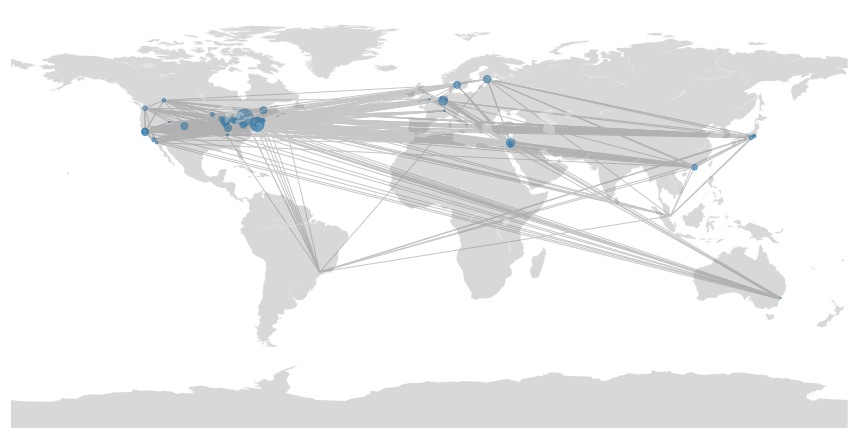

In [96]:
plt.figure(figsize=(15, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
# prepare a color for each point depending on the continent.
data = nodes.iloc[list(G.nodes())].copy()

embedding = data.apply(lambda x: [x.Lon, x.Lat], axis=1)
nx.draw_networkx_edges(G, pos=embedding, edge_color='#C7C7C7')
# Add a point per position
m.scatter(data['Lon'], data['Lat'], s=node_size*2000, 
          cmap=ListedColormap(palette.as_hex()), alpha=0.6)

The most collaboration friendly unis according to betweenness centrality are:

In [97]:
labels

{0: 'University of Colorado at Boulder',
 1: 'Indiana University at Bloomington',
 18: 'University of Illinois at Chicago',
 19: 'University of Toronto',
 26: 'New York University',
 35: 'University of California, Berkeley',
 49: 'University of Pennsylvania',
 53: 'University of Helsinki',
 54: 'Carnegie Mellon University',
 57: 'Göteborg University',
 58: 'University of Haifa',
 80: 'Stanford University',
 81: 'Northwestern University',
 88: 'University of Hong Kong',
 133: 'Michigan State University',
 147: 'Open University of the Netherlands',
 241: 'Université Laval'}

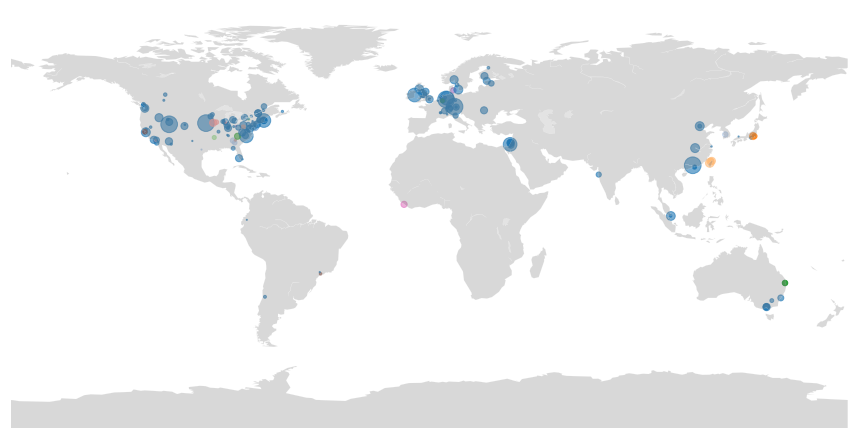

In [98]:
plt.figure(figsize=(15, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
# prepare a color for each point depending on the continent.
data = nodes.iloc[list(largest_cc)].copy()
 
# Add a point per position
m.scatter(data['Lon'], data['Lat'], s=node_size*2000, c=pd.Series(uni_partition).sort_index().tolist(), 
          cmap=ListedColormap(palette.as_hex()), alpha=0.6)


The Universities in each cluster are:

Cluster number:  1


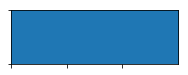

['University of Colorado at Boulder', 'Indiana University at Bloomington', 'Indiana University', 'Technische Universität München', 'Universität Augsburg', 'Ludwig-Maximilians-Universität München', 'University of Edinburgh', 'San Jose State University', 'Harvard University', 'Vanderbilt University', 'University College London, University of London', 'University of Illinois at Chicago', 'University of Toronto', 'Tokyo University', 'Pennsylvania State University', 'New York University', 'Simon Fraser University', 'EPFL - EPF Lausanne', 'Ghent University', 'University of Jyväskylä', 'University of Wisconsin - Madison', 'Arizona State University', 'Hebrew University of Jerusalem', 'University of Texas at Austin', 'University of California, Berkeley', 'Utah State University', 'University of Washington', 'University of Nottingham', 'DePaul University', 'Shizuoka University', 'State University of New York at Albany', 'Pädagogische Hochschule Freiburg', 'Universität Duisburg-Essen', 'University

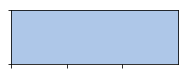

['Macquarie University', 'Ankara University', 'Middle East Technical University', 'Georgia State University', 'Virginia Commonwealth University', 'Texas State University', 'Drexel University', 'Korea Advanced Institute of Science & Technology', 'Worcester Polytechnic Institute', 'University of Warwick', 'Mercer University', 'National University of Singapore', 'University Politehnica of Bucharest', 'Universität der Bundeswehr München, Germany']
Cluster number:  3


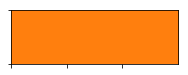

['Tokyo Gakugei University', 'Soka University', 'Yokohama National University', 'The Open University of Japan', 'Senshu University', 'Kobe University', 'Utsunomiya University', 'Ibaraki University']
Cluster number:  4


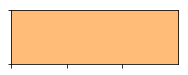

['National Taiwan Normal University', 'National Tsinghua University', 'National Taiwan University of Science and Technology', 'National Hsinchu University of Education', 'National Central University', 'National Taichung University of Science and Technology, Taiwan', 'National Chengchi University']
Cluster number:  5


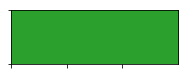

['Griffith University', 'University of Technology Sydney', 'Warren Wilson College', 'Open University', 'Maastricht University', 'Queensland University of Technology']
Cluster number:  6


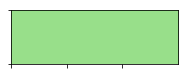

['Kansas State University', 'Universität Köln', 'Rochester Institute of Technology', 'University of Central Arkansas']
Cluster number:  7


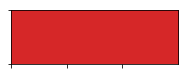

['University of Iowa', 'Central College', 'University of California, Irvine', 'University of Chicago']
Cluster number:  8


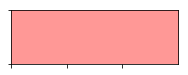

['University of Southern Denmark - SDU', 'Ohio State University, Columbus', 'University of New Mexico']
Cluster number:  9


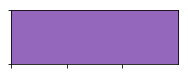

['Temple University', 'University of Delaware']
Cluster number:  10


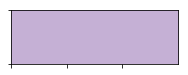

['Sony Interactive Entertainment', 'Universidade de São Paulo']
Cluster number:  11


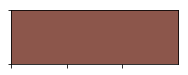

['University of Georgia', 'West Virginia University']
Cluster number:  12


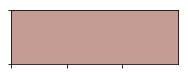

['Nanyang Technological University', 'Ministry of Education']


In [99]:
for i, m in enumerate(list(greedy_modularity_communities(main_universities))):
    unis = nodes.iloc[list(m)]
    unis = unis[unis.name.map(lambda x: True if reg.search('\p{Lu}',x) else False)].name.unique().tolist() 
    if len(unis) > 1:
        print('Cluster number: ', i+1)
        sns.palplot(palette[i])
        plt.show()
        print(unis)